# Cycle Consistency Loss is obsolete

Proof:

1. Copy an edit any succesfull cyclegan notebook ([Monet-GAN](https://www.kaggle.com/animesh2099/monet-gan) or [notebook2 gan](https://www.kaggle.com/ankita74/notebook2-gan) for example)

2. Delete " + total_cycle_loss " term from total_monet_gen_loss equations in train_step method.
            total_monet_gen_loss = monet_gen_loss +  self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
    
3. You may also delete/comment strings responsible for reconstruction and photo generation:
            #cycled_photo = self.p_gen(fake_monet, training=True)
            #fake_photo = self.p_gen(real_monet, training=True)
            #cycled_monet = self.m_gen(fake_photo, training=True) 
            #disc_real_photo = self.p_disc(real_photo, training=True)
            #same_photo = self.p_gen(real_photo, training=True)
            #photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            #total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            #photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            #total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
        #photo_generator_gradients = tape.gradient(total_photo_gen_loss,self.p_gen.trainable_variables)
        #photo_discriminator_gradients = tape.gradient(photo_disc_loss,self.p_disc.trainable_variables)        
        #self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        #self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
            #"photo_gen_loss": total_photo_gen_loss,
            #"photo_disc_loss": photo_disc_loss

4. Compensate some regularization

    lambda_cycle=150


5. It is a one-sided translation model now. Identity loss is the only regularization. Run it.

6. Compare results to cyclegan with the same parameters.

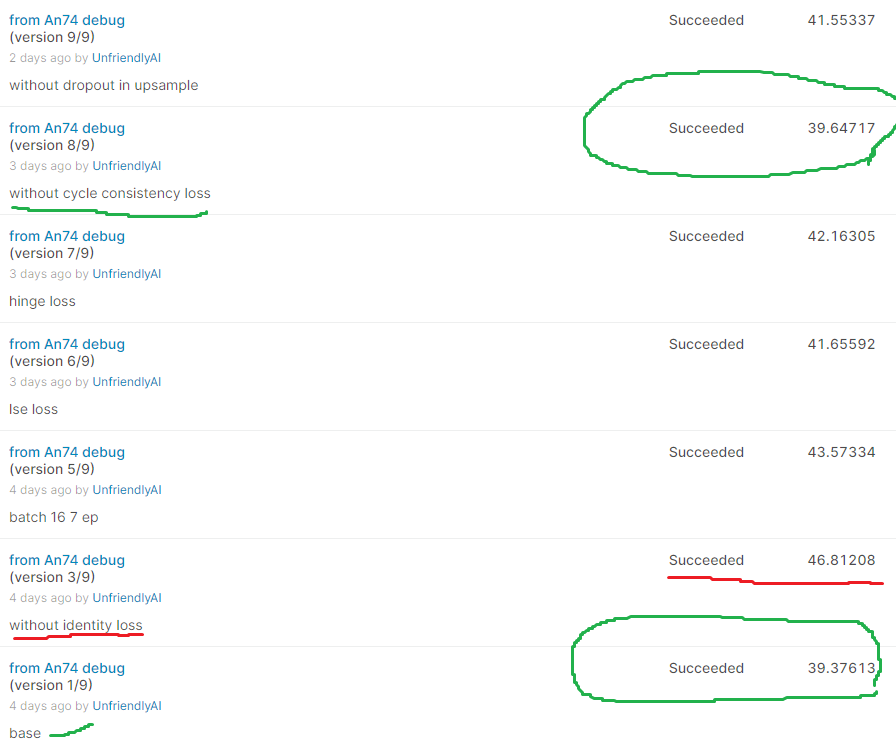

Conclusion: the model without cycle consistency loss is in no way inferior to a cyclgan with the same parameters. Any other change has a huge impact on the outcome. Identity Loss can help to avoid mode collapse and provide correct translation. We don't need cycle consistency loss anymore.


Version 5+: DiffAugment added. Now we can compare rusults to "Diffaugment is all you need" notebook

# Why Cycle consistency loss is harmful
Why are we using Cycle consistency loss? We assume that translated image can be reconstructed. But this is not the case. Some data has been lost. If we convert zebras to horses, we lose stripes and the models cannot restore stripes in the correct places. If the generator turns the horses back into zebras, it could place stripes in completely wrong places. What does the cycle consistency loss say? A very bad zebra! What will the model do next time? It will encode stripes on the "horses" image to reconstruct later!

To demonstrate the possibilities of encoding, I have inverted the Monet generator's adversarial loss asking "make the least real Monet!". The result is gray squares. But from these gray squares the photo generator reconstructed the original photos!


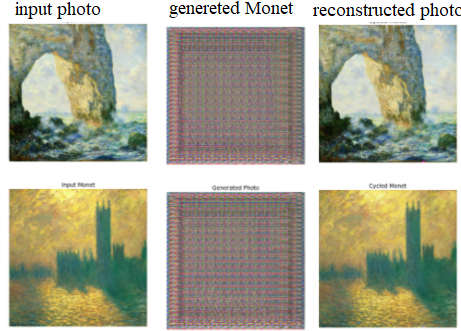

But this is only one part of the Cycle consistency loss problem. As for image-to-image translation, we want the model to be accurate. A tree must be translated as a tree. All semantics must be preserved. But there is no motivation for this in Cycle consistency loss. The only motivation is to encode the original image into a translated image.

So Cycle consistency loss is useless. Then duplicating generators and discriminators is also useless. We should start with a regular GAN looking for good objective function.

> ### Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import re
import PIL
import os
import shutil

>### Configure TPU

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

>### Get image data from google cloud storage

In [ ]:
# Google Cloud Storage path for dataset
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

In [ ]:
# Size of input data
MONET_FILES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in MONET_FILES]
n_monet = np.sum(n)
n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in PHOTO_FILES]
n_photo = np.sum(n)

print(f'Monet image files: {n_monet}')
print(f'Photo image files: {n_photo}')

>### Function to read image (tensorflow record)

In [ ]:
def read_tfrecord(example):# read image
    IMAGE_SIZE = [256, 256]
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    im = example['image']
    
    image = tf.image.decode_jpeg(im, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

>### Input image data augmentation

In [ ]:
def augment_image(image): # input data augmentation
    x = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    y = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if y > .5: # random crop image
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
            
    if x > .6: # random flip image
        image = tf.image.random_flip_left_right(image)
    
    return image

>### Load Dataset

In [ ]:
# Function to load dataset
def load_data(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

monet_ds = load_data(MONET_FILES).batch(1)
photo_ds = load_data(PHOTO_FILES).batch(1)


fast_photo_ds = load_data(PHOTO_FILES).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_photo_ds = load_data(PHOTO_FILES).take(1024).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_monet_ds = load_data(MONET_FILES).batch(32*strategy.num_replicas_in_sync).prefetch(32)

def gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_data(monet_files)
    photo_ds = load_data(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
#     if shuffle:
#         monet_ds = monet_ds.shuffle(2048)
#         photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
#     monet_ds = monet_ds.cache()
#     photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

# Load dataset
data = gan_dataset(MONET_FILES, PHOTO_FILES, augment=None, repeat=True, shuffle=True, batch_size=16)

In [ ]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False

    
    
    def calculate_activation_statistics_mod(images,fid_model):

            act=tf.cast(fid_model.predict(images), tf.float32)

            mu = tf.reduce_mean(act, axis=0)
            mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
            mx = tf.matmul(tf.transpose(mean_x), mean_x)
            vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
            sigma = vx - mx
            return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_monet_ds,inception_model)        
    fids=[]

In [ ]:
with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14
       
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
#         isgood=tf.cast(tf.math.is_finite(covmean), tf.int32)
#         if tf.size(isgood)!=tf.math.reduce_sum(isgood):
#             return 0

        covmean = tf.cast(tf.math.real(covmean),tf.float32)
  
        tr_covmean = tf.linalg.trace(covmean)


        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean


    
    
    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
                inp = layers.Input(shape=[256, 256, 3], name='input_image')
                x  = gen_model(inp)
                x=inception_model(x)
                fid_model = tf.keras.Model(inputs=inp, outputs=x)
                
                mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)

                fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)


                return fid_value

>### Main code

In [ ]:
def down_sample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

In [ ]:
def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

In [ ]:
def generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False),# (size, 128, 128, 64)
        down_sample(128, 4),                         # (size, 64, 64, 128)
        down_sample(256, 4),                         # (size, 32, 32, 256)
        down_sample(512, 4),                         # (size, 16, 16, 512)
        down_sample(512, 4),                         # (size, 8, 8, 512)
        down_sample(512, 4),                         # (size, 4, 4, 512)
        down_sample(512, 4),                         # (size, 2, 2, 512)
        down_sample(512, 4),                         # (size, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),       # (size, 2, 2, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 4, 4, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 8, 8, 1024)
        up_sample(512, 4),                           # (size, 16, 16, 1024)
        up_sample(256, 4),                           # (size, 32, 32, 512)
        up_sample(128, 4),                           # (size, 64, 64, 256)
        up_sample(64, 4),                            # (size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 
    # (size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    down1 = down_sample(64, 4, False)(x)       # (size, 128, 128, 64)
    down2 = down_sample(128, 4)(down1)         # (size, 64, 64, 128)
    down3 = down_sample(256, 4)(down2)         # (size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (size, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (size, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
class Gan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=150,
    ):
        super(Gan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(Gan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
#             cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
#             fake_photo = self.p_gen(real_monet, training=True)
#             cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
#             same_photo = self.p_gen(real_photo, training=True)


################## My code #####################
            
            both_monet = tf.concat([real_monet, fake_monet], axis=0)            
            
            aug_monet = aug_fn(both_monet)
            
            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]
            
################ End of my code #################
            
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(aug_real_monet, training=True)
#             disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(aug_fake_monet, training=True)
#             disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
#             photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
#             total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
#             total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
#             photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
#         photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
#         photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
#         self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
#         self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
#             "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
#             "photo_disc_loss": photo_disc_loss
        }

>### Generate images and send to discriminator

In [ ]:
with strategy.scope(): # for TPU
    monet_generator = generator() # transforms photos to Monet paintings
    photo_generator = generator() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator() # differentiates real photos and generated photos


In [ ]:
with strategy.scope(): # for TPU
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope(): # for TPU
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope(): # for TPU
    def calculate_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope(): # for TPU
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [ ]:
with strategy.scope():
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738
# from https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py



    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
}
    def aug_fn(image):
        return DiffAugment(image,"color,translation,cutout")

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=6, every_n_epoch=1):
        self.num_img = num_img
        self.every_n_epoch = every_n_epoch
        self.bestfid=99999999999

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.every_n_epoch != 0:
            return
        _, ax = plt.subplots(self.num_img, 2,figsize=(76, 76))
        for i, img in enumerate(monet_ds.take(self.num_img)):
            prediction = self.model.p_gen(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")


        plt.show()
        plt.close()
        cur_fid=FID(fid_photo_ds,self.model.m_gen)
        fids.append(cur_fid[0][0])
        print("After epoch #{} FID = {} \n".format(epoch+1,cur_fid))
        if cur_fid<self.bestfid:
                self.bestfid=cur_fid
                monet_generator.save_weights('monet_generator.h5')


plotter = GANMonitor()

>### Compile GAN

In [ ]:
with strategy.scope(): # for TPU
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope(): # for TPU
    gan_model = Gan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calculate_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
gan_model.fit(data, epochs=11, steps_per_epoch=(max(n_monet, n_photo)//4),callbacks=[plotter])

In [ ]:
with strategy.scope(): # for TPU
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
with strategy.scope(): # for TPU
    gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calculate_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
gan_model.fit(data, epochs=6, steps_per_epoch=(max(n_monet, n_photo)//4),callbacks=[plotter])

>### Generate and save the ouput

In [ ]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [ ]:
os.makedirs('../images/')
predict_and_save(load_data(PHOTO_FILES).batch(1), monet_generator, '../images/')
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')
print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")